# Generated Dissimilarity datasets

In [1]:
import os
os.environ['MEMORY_LIMIT'] = '16GB'
import seaborn as sns
import numpy as np
import scipy as scp
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib import gridspec
from os.path import exists, join
from io import StringIO  
from datetime import timedelta
import math

ALGORITHMS = {
    'structural': 'Structural',
    'structural-variant': 'Splitted Structural',
    'sed': 'Sed',
    'lblint': 'Lbl-Int',
    'bib': 'Binary branch',
    'sedindex': 'Sed Index',
    'lblindex': 'Lbl-Int Index',
    'structuralindex': 'Structural Index',
}

datasets = ('dblp', 'ptb', 'python', 'sentiment', 'swissprot', 'treefam')
ALGORITHMS_ENUM_NAMES = {
    'structural': 'Structural',
    'structural-variant': 'StructuralVariant',
    'sed': 'Sed',
    'lblint': 'Lblint',
    'bib': 'Bib'
}

In [2]:
bases = [f'base-{b}' for b in [25,100,200]]
datasets = [f'{base}/{x}' for x in ['lsmall', 'lbig'] for base in bases]

In [3]:
from os.path import join
def get_query_runtime_for_ds(basepath: str, ds: str):
    qt = join(basepath, ds, 'query_times.txt')
    # qt = f'resources/workloads/generated/{ds}/query_times.txt'
    with open(qt) as f:
        content = f.read()
    times = [l.split(':')[1].strip('ms') for i, l in enumerate(content.split('\n')) if i % 3 == 1]
    candidates = [l.split(':')[1] for i, l in enumerate(content.split('\n')) if i % 3 == 2]
    methods = [l for i, l in enumerate(content.split('\n')) if i % 3 == 0 and l]
    csv_content = ','.join(methods) + '\n' +','.join(times)  + '\n' + ','.join(candidates) + '\n'
    strio = StringIO(csv_content)
    df = pd.read_csv(strio)
    df.insert(0, 'Dataset', [ds] * 2)
    # df = df.set_index('Dataset')
    return df

In [4]:
def get_searching_part(basepath: str):
    df = pd.DataFrame()
    cdf = pd.DataFrame()
    stats_df = pd.DataFrame()
    for ds in datasets:
        tdf = get_query_runtime_for_ds(basepath, ds)
        df = pd.concat([df, tdf.iloc[[0]]])
        cdf = pd.concat([cdf, tdf.iloc[[1]]])
        stats = pd.read_csv(join(basepath, ds, 'collection.csv'))
        stats.insert(0, 'Dataset', [ds.capitalize()])
        stats_df = pd.concat([stats_df, stats])

    df = df.rename(columns={
        'Lblint index': ALGORITHMS['lblindex'],
        'Lblint': ALGORITHMS['lblint'],
        'Sed Index': ALGORITHMS['sedindex'],
        'Sed': ALGORITHMS['sed'],
        'Structural Index': ALGORITHMS['structuralindex'],
        'Structural': ALGORITHMS['structural'],
        })
    df = df.set_index('Dataset')
    cdf = cdf.set_index('Dataset')
    df['process_part'] = 'searching'

    return df, cdf, stats_df

In [5]:
# returns precision, verification times and selectivies
def get_precision_and_verification_for_ds(basepath: str, cdf: pd.DataFrame) -> (pd.DataFrame, pd.DataFrame, pd.DataFrame):
    # precision dataframe
    pdf = pd.DataFrame()
    # verification times dataframe
    vdf = pd.DataFrame()
    selectivites = dict()
    for ds in datasets:
        temp_df = pd.DataFrame.from_dict({ 'dataset': [ds] })
        tv_df = pd.DataFrame.from_dict({ 'Dataset': [ds] })
        times_ = []
        methods = ['Lbl-Int Index', 'Lbl-Int', 'Sed Index', 'Sed', 'Structural Index', 'Structural']
        for mtd in ('Lblint', 'Sed', 'Structural'):
            verification_path = join(basepath, ds, f'{mtd.lower()}-verified.txt')
            candidate_count = cdf[mtd][ds]
            
            with open(verification_path) as f:
                lines = f.read().split('\n')
            times = pd.Series([float(t) for t in lines if ',' not in t and t])
            correct_results = [l for l in lines if ',' in l and l]
            # candidate_count = 
            precision =  len(correct_results) / candidate_count
            # print(mtd, ds, candidate_count, len(correct_results))
            temp_df[mtd] = precision
            temp_df
    
            total_verification_time_ms = times.div(1_000_000).sum()
            # twice for index version
            times_.extend([total_verification_time_ms, total_verification_time_ms])
            # print(ds, mtd, precision)
        
        sdf = pd.read_csv(StringIO('\n'.join(correct_results)), names=['T1', 'T2'])
        sdf = sdf[sdf['T1'] != sdf['T2']].sort_values(by='T1')
        m = sdf.groupby('T1').count().mean(axis=0)
        selectivity = 100 * ((m.reset_index()[0][0]) / 1000)
        selectivites[ds] = {'Selectivity':  selectivity }
        pdf = pd.concat([pdf, temp_df])
        vdf = pd.concat([vdf, pd.DataFrame.from_dict({'Dataset': [ds] * 6, 'process_part': ['verification'] * 6, 'Method': methods, 'Time': times_, }) ])
        
    
    sdf = pd.DataFrame.from_dict(selectivites)
    pdf = pdf.set_index("dataset")
    vdf.sort_values(['Method', 'Dataset'], inplace=True)
    return pdf, vdf, sdf


In [6]:
def plot_selectivity(sdf):
    # plt.figure(figsize=(18, 12))
    bx = sns.barplot(sdf, width=0.6)
    # bx.tick_params(axis='x', rotation=45, rotation_mode='anchor'labelsize=10, ha='left')
    bx.set_xticklabels(bx.get_xticklabels(), 
                       rotation=45,     # Rotation angle
                       ha='right',      # Horizontal alignment: 'left', 'center', or 'right'
                       rotation_mode='anchor')  # Ensures alignment works with rotation
    
    # Add value annotations on top of each bar
    for i, ds in enumerate(datasets):
        v = sdf[ds]['Selectivity']
        bx.text(i, round(v, 2), str(round(v, 2)) + '%', 
                ha='center', va='bottom',  # horizontally centered, placed just above the bar
                fontweight='bold')
    return bx


In [7]:
def plot_precision(pdf, ax=None):
    return sns.heatmap(pdf, annot=True, ax=ax)

In [8]:
from dataclasses import dataclass

In [9]:
@dataclass
class PlotData:
    pdf: pd.DataFrame
    vdf: pd.DataFrame
    sdf: pd.DataFrame
    plotdata: pd.DataFrame
    statistics: pd.DataFrame
    dissimilarity: pd.DataFrame | None = None

In [10]:
def get_plot_data_ds(basepath: str) -> PlotData:
    df, cdf, statistics = get_searching_part(basepath)
    pdf, vdf, sdf = get_precision_and_verification_for_ds(basepath, cdf)
    
    
    df['Dataset'] = df.index
    ldf = df.melt(id_vars=["Dataset", "process_part"], var_name="Method", value_name="Time", value_vars=['Lbl-Int Index', 'Lbl-Int', 'Sed Index', 'Sed', 'Structural Index', 'Structural'])
    complete = pd.concat([ldf, vdf])
    plot_data = complete.pivot_table(
        index=['Dataset', 'Method'],
        columns='process_part',
        values='Time'
    ).reset_index()
    plot_data['total'] = plot_data['searching'] + plot_data['verification']

    return PlotData(
        pdf = pdf,
        vdf = vdf,
        sdf = sdf,
        plotdata = plot_data,
        statistics = statistics,
    )

In [11]:
hue_color_palette = {'searching': sns.color_palette()[0], 'verification': sns.color_palette()[1]}

# 10 - 20 distinct labels per tree

In [12]:
data: PlotData = get_plot_data_ds('resources/workloads/generated-1-5')

In [13]:
display(data.statistics)

,Dataset,min_tree,max_tree,avg_tree,tree_count,avg_unique_labels_per_tree,avg_tree_distinct_labels,distinct_labels,Unnamed: 7
0,Base-25/lsmall,90,124,106.673,1000,0.041,21.455,2994,NaN
0,Base-100/lsmall,89,121,105.097,1000,0.058,19.804,2996,NaN
0,Base-200/lsmall,89,123,104.706,1000,0.087,17.658,2987,NaN
0,Base-25/lbig,91,122,106.260,1000,12.891,21.482,15494,NaN
0,Base-100/lbig,88,121,104.980,1000,12.105,19.935,14527,NaN
0,Base-200/lbig,91,122,104.758,1000,11.056,17.900,13336,NaN


<Axes: ylabel='dataset'>

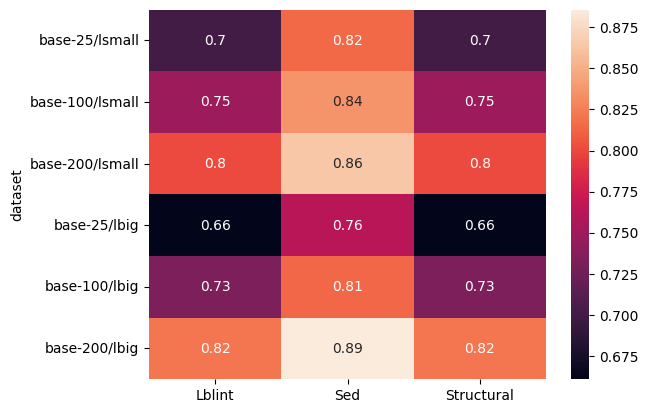

In [14]:
plot_precision(data.pdf)

In [15]:
alldf = pd.melt(data.plotdata, id_vars=['Dataset', 'Method'], value_vars=['searching', 'verification'], value_name="time")
alldf[['BaseSize', 'LabelSize']] = alldf['Dataset'].str.split('/', expand=True)
alldf[['Base', 'BaseSize']] = alldf['BaseSize'].str.split('-', expand=True)
alldf.drop('Base', axis=1, inplace=True)
alldf['BaseSize'] = alldf['BaseSize'].astype(int)

/tmp/ipykernel_18490/540418489.py:31: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(order, rotation=45, ha="right")  # Rotate labels by 45 degrees
/tmp/ipykernel_18490/540418489.py:31: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(order, rotation=45, ha="right")  # Rotate labels by 45 degrees
/tmp/ipykernel_18490/540418489.py:31: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(order, rotation=45, ha="right")  # Rotate labels by 45 degrees
/tmp/ipykernel_18490/540418489.py:31: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(order, rotation=45, ha="right")  # Rotate labels by 45 degrees


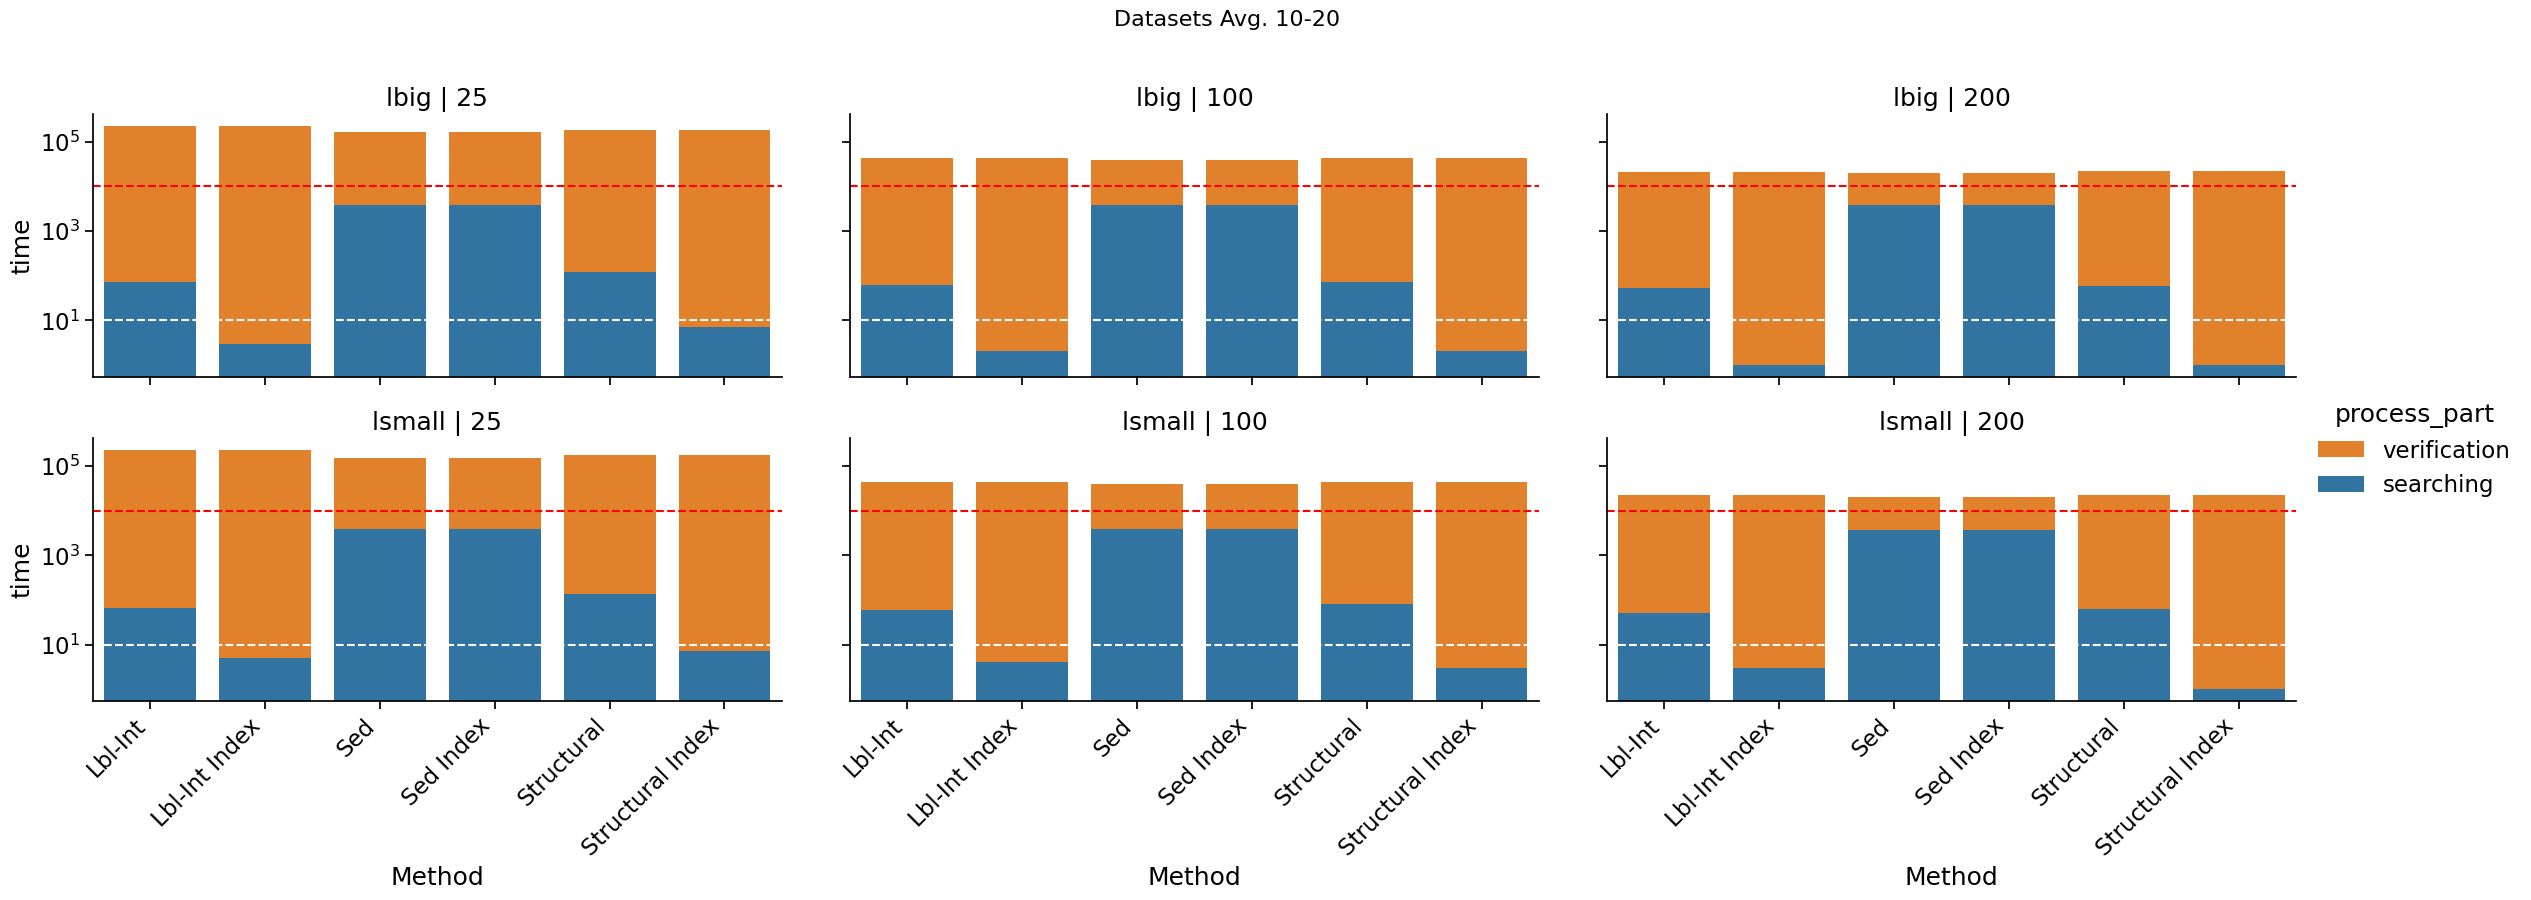

In [16]:
order = ['Lbl-Int', 'Lbl-Int Index', 'Sed', 'Sed Index', 'Structural', 'Structural Index']
# Increase overall font size
sns.set_context("notebook", font_scale=1.5)
g = sns.FacetGrid(
    alldf.sort_values('process_part', ascending=False).sort_values('Method'),
    col = 'BaseSize',
    row = 'LabelSize',
    hue = 'process_part',
    palette = hue_color_palette,
    height=4, aspect=2
    )
g = (g.map(sns.barplot, 'Method', 'time', errorbar = None, order=order).add_legend())

g.set(yscale='log')

# Increase font size for titles, labels, and ticks
g.set_titles('{row_name} | {col_name}')   # Increase font size of titles
# g.set_axis_labels('Base Size', 'Value', fontsize=28)  # Axis labels font size
axes = g.axes.flatten()
for ax in axes:
    ax.axhline(y=10_000, color='r', linestyle='--')
    ax.axhline(y=10, color='white', linestyle='--')

# Set the super title
g.fig.suptitle("Datasets Avg. 10-20", fontsize=16)

# Adjust layout to make space for the super title
g.fig.subplots_adjust(top=0.85)  # Adjust this value as needed
# Rotate x-tick labels
for ax in g.axes.flat:
    ax.set_xticklabels(order, rotation=45, ha="right")  # Rotate labels by 45 degrees


# plt.suptitle('Times for 30-50 datasets')
# g.fig.subplots_adjust(hspace=0.2, wspace=0.35)
plt.show()
sns.set_context("notebook", font_scale=1)

# Distinct labels 30-50 per tree

In [17]:
data: PlotData = get_plot_data_ds('resources/workloads/generated-150-200')

In [18]:
display(data.statistics)

,Dataset,min_tree,max_tree,avg_tree,tree_count,avg_unique_labels_per_tree,avg_tree_distinct_labels,distinct_labels,Unnamed: 7
0,Base-25/lsmall,91,122,106.331,1000,0.015,85.978,2996,NaN
0,Base-100/lsmall,91,121,104.835,1000,0.007,84.887,3001,NaN
0,Base-200/lsmall,90,125,104.767,1000,0.001,84.215,3001,NaN
0,Base-25/lbig,91,122,106.096,1000,12.302,87.102,16510,NaN
0,Base-100/lbig,89,123,105.586,1000,10.487,85.689,19296,NaN
0,Base-200/lbig,91,122,105.426,1000,8.509,85.448,22874,NaN


<Axes: ylabel='dataset'>

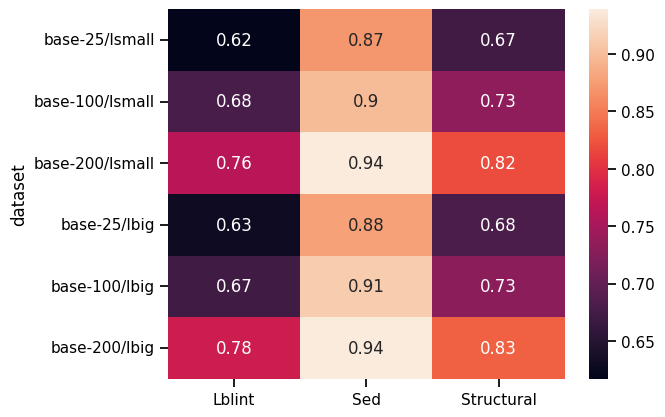

In [19]:
plot_precision(data.pdf)

In [20]:
alldf = pd.melt(data.plotdata, id_vars=['Dataset', 'Method'], value_vars=['searching', 'verification'], value_name="time")
alldf[['BaseSize', 'LabelSize']] = alldf['Dataset'].str.split('/', expand=True)
alldf[['Base', 'BaseSize']] = alldf['BaseSize'].str.split('-', expand=True)
alldf.drop('Base', axis=1, inplace=True)
alldf['BaseSize'] = alldf['BaseSize'].astype(int)

/tmp/ipykernel_18490/1778216415.py:33: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(order, rotation=45, ha="right")  # Rotate labels by 45 degrees
/tmp/ipykernel_18490/1778216415.py:33: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(order, rotation=45, ha="right")  # Rotate labels by 45 degrees
/tmp/ipykernel_18490/1778216415.py:33: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(order, rotation=45, ha="right")  # Rotate labels by 45 degrees
/tmp/ipykernel_18490/1778216415.py:33: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(order, rotation=45, ha="right")  # Rotate labels by 45 degr

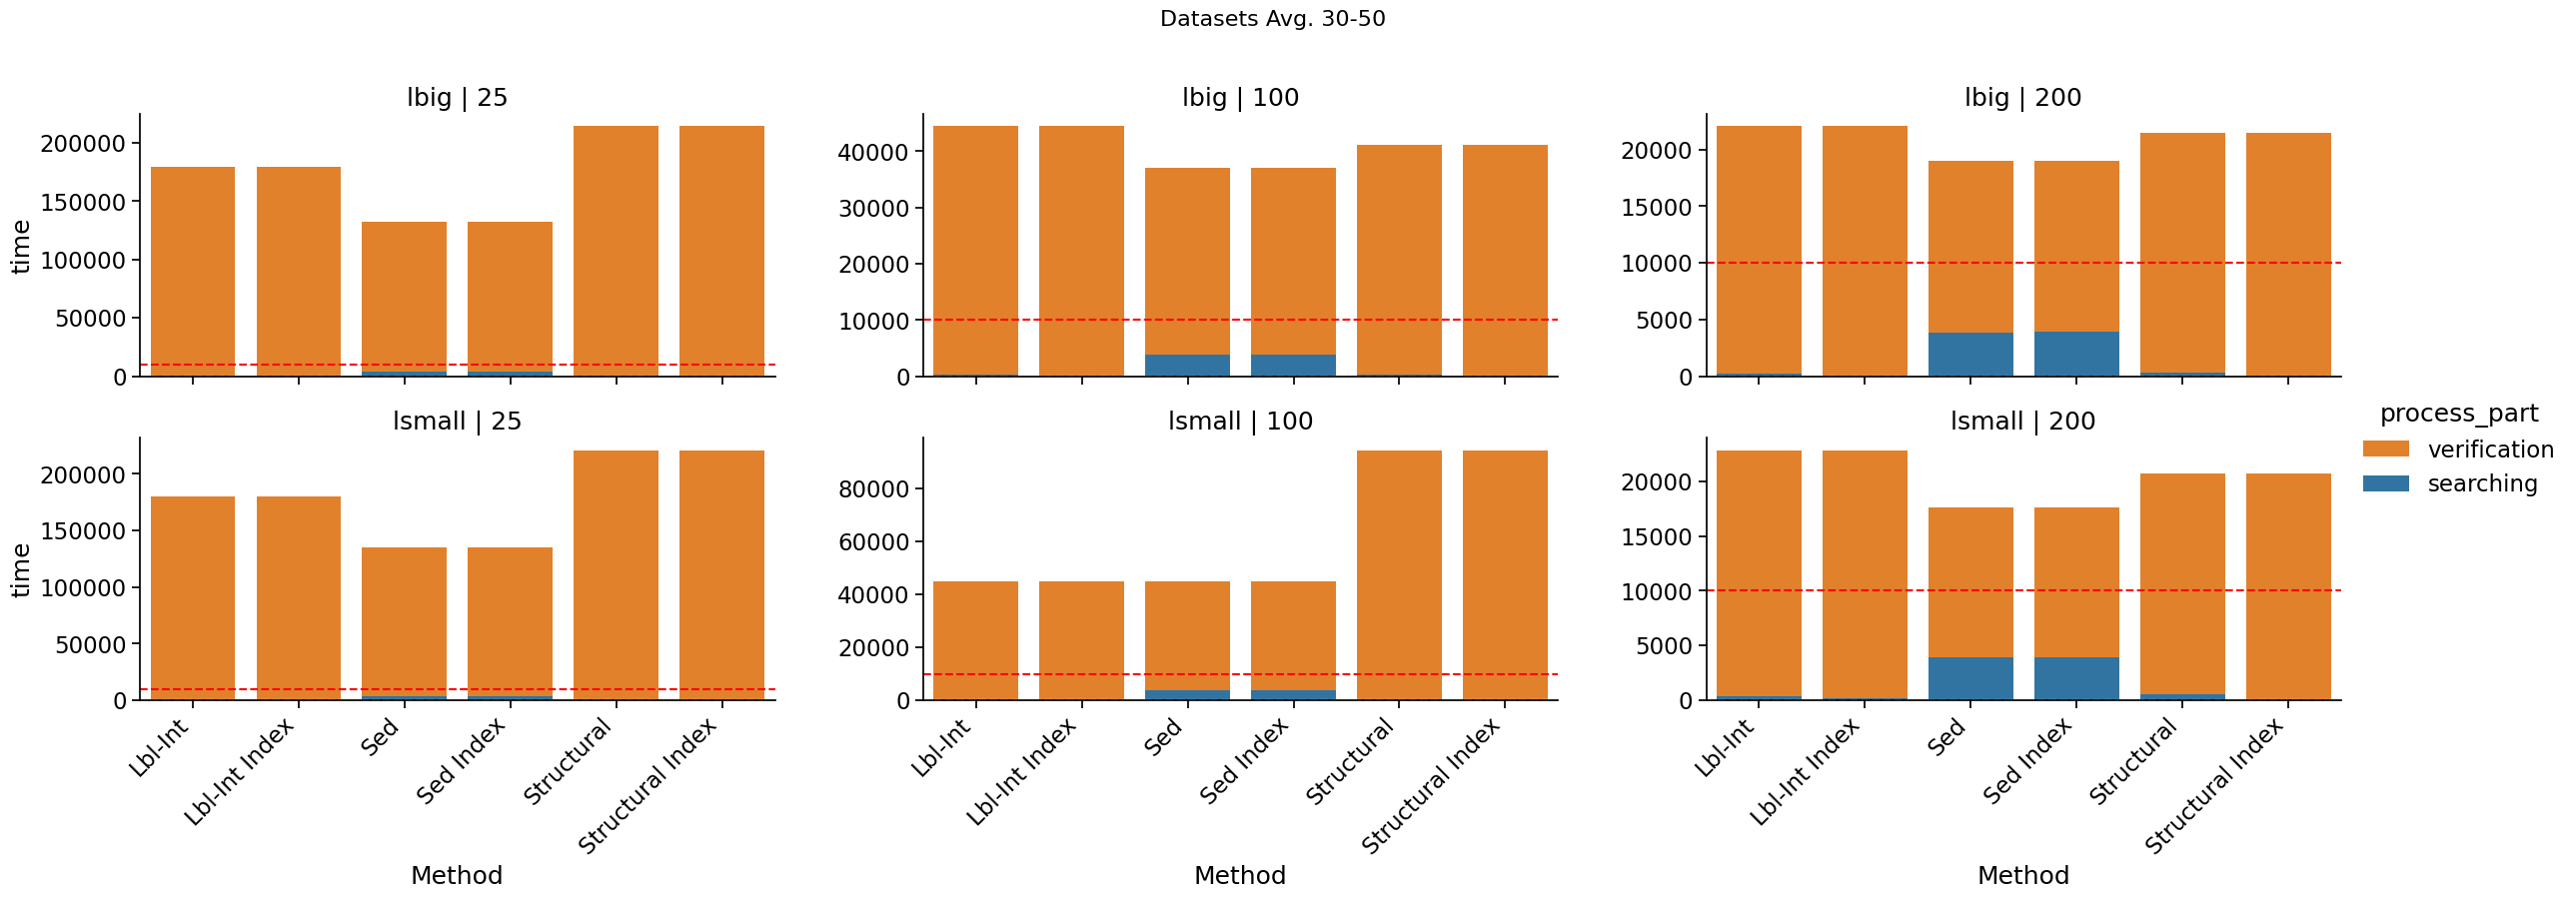

In [21]:
order = ['Lbl-Int', 'Lbl-Int Index', 'Sed', 'Sed Index', 'Structural', 'Structural Index']
# Increase overall font size
sns.set_context("notebook", font_scale=1.5)
g = sns.FacetGrid(
    alldf.sort_values('process_part', ascending=False).sort_values('Method'),
    col = 'BaseSize',
    sharey=False,
    row = 'LabelSize',
    hue = 'process_part',
    palette = hue_color_palette,
    height=4, aspect=2
    )
g = (g.map(sns.barplot, 'Method', 'time', errorbar = None, order=order).add_legend())

# g.set(yscale='log')

# Increase font size for titles, labels, and ticks
g.set_titles('{row_name} | {col_name}')   # Increase font size of titles
# g.set_axis_labels('Base Size', 'Value', fontsize=28)  # Axis labels font size
axes = g.axes.flatten()
for ax in axes:
    ax.axhline(y=10_000, color='r', linestyle='--')
    ax.axhline(y=10, color='white', linestyle='--')
    # ax.set_yscale('log', base=math.e)

# Set the super title
g.fig.suptitle("Datasets Avg. 30-50", fontsize=16)

# Adjust layout to make space for the super title
g.fig.subplots_adjust(top=0.85)  # Adjust this value as needed
# Rotate x-tick labels
for ax in g.axes.flat:
    ax.set_xticklabels(order, rotation=45, ha="right")  # Rotate labels by 45 degrees


# plt.suptitle('Times for 30-50 datasets')
# g.fig.subplots_adjust(hspace=0.2, wspace=0.35)
plt.show()
sns.set_context("notebook", font_scale=1)

# Avg. distinct labels 70 - 90 per tree

In [22]:
data: PlotData = get_plot_data_ds('resources/workloads/generated-70-90')

In [23]:
display(data.statistics)

,Dataset,min_tree,max_tree,avg_tree,tree_count,avg_unique_labels_per_tree,avg_tree_distinct_labels,distinct_labels,Unnamed: 7
0,Base-25/lsmall,92,118,104.972,1000,0.105,66.982,2973,NaN
0,Base-100/lsmall,90,118,104.230,1000,0.036,66.275,2992,NaN
0,Base-200/lsmall,91,122,102.858,1000,0.006,64.708,2999,NaN
0,Base-25/lbig,88,119,104.114,1000,9.927,66.867,12541,NaN
0,Base-100/lbig,88,117,102.998,1000,8.589,66.091,14910,NaN
0,Base-200/lbig,91,117,102.890,1000,6.977,65.326,17836,NaN


<Axes: ylabel='dataset'>

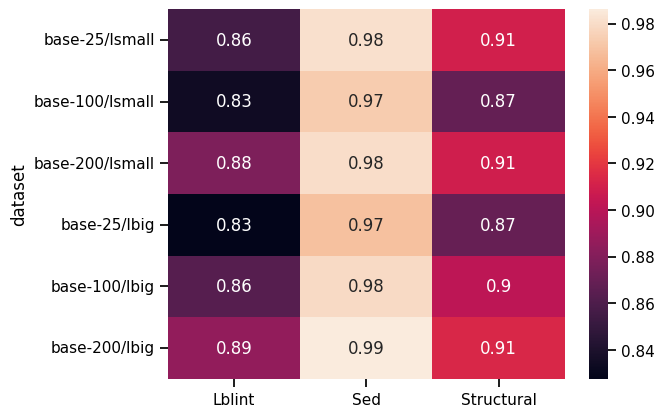

In [24]:
plot_precision(data.pdf)

In [25]:
alldf = pd.melt(data.plotdata, id_vars=['Dataset', 'Method'], value_vars=['searching', 'verification'], value_name="time")
alldf[['BaseSize', 'LabelSize']] = alldf['Dataset'].str.split('/', expand=True)
alldf[['Base', 'BaseSize']] = alldf['BaseSize'].str.split('-', expand=True)
alldf.drop('Base', axis=1, inplace=True)
alldf['BaseSize'] = alldf['BaseSize'].astype(int)

In [26]:
data.plotdata[['BaseSize', 'LabelSize']] = data.plotdata['Dataset'].str.split('/', expand=True)
data.plotdata[['Base', 'BaseSize']] = data.plotdata['BaseSize'].str.split('-', expand=True)
data.plotdata.drop('Base', axis=1, inplace=True)
data.plotdata['BaseSize'] = data.plotdata['BaseSize'].astype(int)
data.plotdata

process_part,Dataset,Method,searching,verification,total,BaseSize,LabelSize
0,base-100/lbig,Lbl-Int,187.0,39926.059287,40113.059287,100,lbig
1,base-100/lbig,Lbl-Int Index,10.0,39926.059287,39936.059287,100,lbig
2,base-100/lbig,Sed,3569.0,35557.990246,39126.990246,100,lbig
3,base-100/lbig,Sed Index,3619.0,35557.990246,39176.990246,100,lbig
4,base-100/lbig,Structural,205.0,38432.435468,38637.435468,100,lbig
5,base-100/lbig,Structural Index,4.0,38432.435468,38436.435468,100,lbig
6,base-100/lsmall,Lbl-Int,213.0,42470.018111,42683.018111,100,lsmall
7,base-100/lsmall,Lbl-Int Index,60.0,42470.018111,42530.018111,100,lsmall
8,base-100/lsmall,Sed,3723.0,37642.994447,41365.994447,100,lsmall
9,base-100/lsmall,Sed Index,3715.0,37642.994447,41357.994447,100,lsmall


In [27]:
hue_color_palette

{'searching': (0.12156862745098039, 0.4666666666666667, 0.7058823529411765),
 'verification': (1.0, 0.4980392156862745, 0.054901960784313725)}

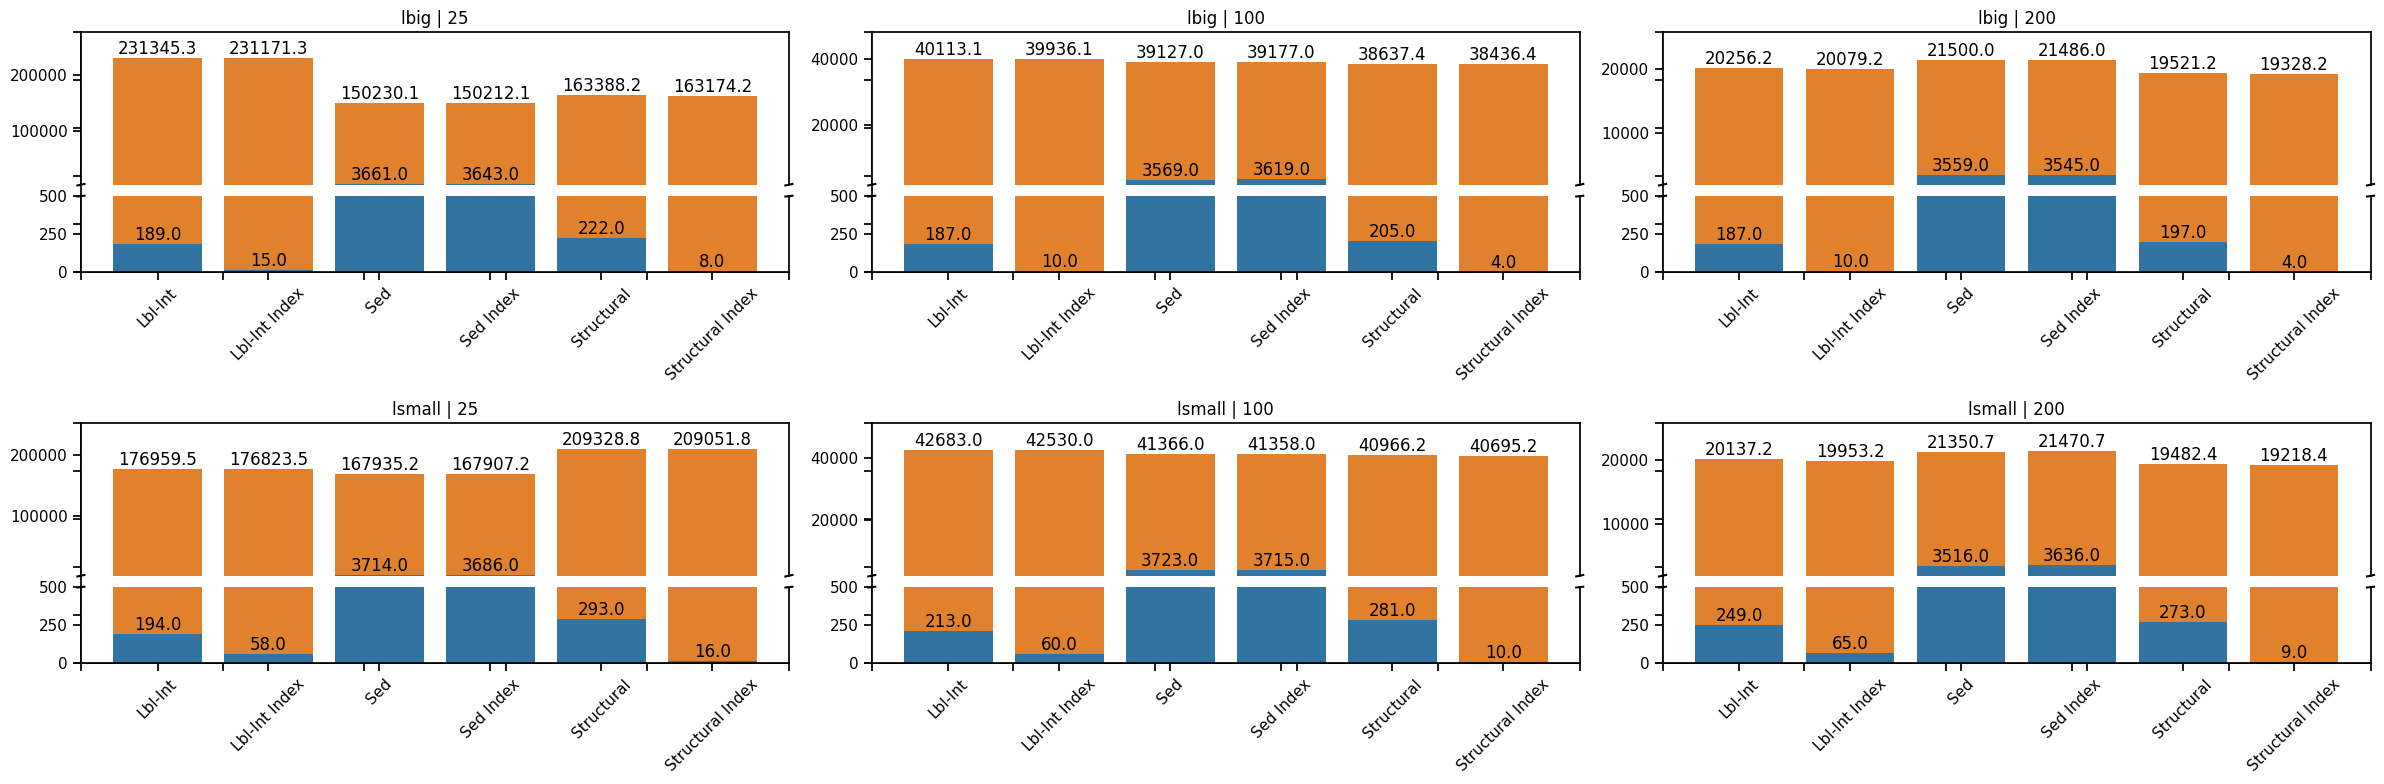

In [28]:
sns.set_context("notebook", font_scale=1)
# Updated function to handle `FacetGrid` subsets
def plot_broken_stacked_bars(data, order, break_bottom=15, break_top=450, height_ratios=[2, 1], *args, **kwargs):
    # print(kwargs)
    # print(kwargs)
    # display(data)
    """Create a broken axis stacked bar plot"""
    # Create figure and gridspec
    ax = plt.gca()
    gs = gridspec.GridSpecFromSubplotSpec(2, 1, subplot_spec=ax.get_subplotspec(), height_ratios=height_ratios, hspace=0.10)

    
    # Create two axes
    ax1 = plt.Subplot(ax.figure, gs[0])
    ax2 = plt.Subplot(ax.figure, gs[1])
    ax.figure.add_subplot(ax1)
    ax.figure.add_subplot(ax2)

    # ax.set_xticks(data["Method"])
    # Plot stacks on both axes
    for ax in [ax1, ax2]:
        # Bottom stack
        sns.barplot(data=data, x='Method', y='searching', 
                   color=hue_color_palette['searching'], ax=ax, order=order)
        
        # Top stack
        sns.barplot(data=data, x='Method', y='verification',
                   bottom=data['searching'],
                   color=hue_color_palette['verification'], ax=ax, order=order)
        # ax.set_xticks([])
        ax.set_xlabel("") #Remove x label
        ax.set_ylabel("") #Remove y label

    for i, total in enumerate(data['total']):
        if total > break_top:
            ax1.text(i, total, f'{total:.1f}', ha='center', va='bottom')

    for i, search_time in enumerate(data['searching']):
        subax = ax2 if search_time < break_bottom else ax1
        # if search_time < break_bottom:
        subax.text(i, search_time, f'{search_time:.1f}', ha='center', va='bottom')
                        
    # Set the limits
    ax1.set_ylim(break_top, data['total'].max() * 1.2)
    ax2.set_ylim(0, break_bottom)
    
    # Hide the appropriate spines
    ax1.spines['bottom'].set_visible(False)
    ax2.spines['top'].set_visible(False)
    ax1.xaxis.set_visible(False)
    
    # Add break marks
    d = .005
    kwargs = dict(transform=ax2.transAxes, color='k', clip_on=False)
    ax2.plot((-d, +d), (1-d, 1+d), **kwargs)
    ax2.plot((1-d, 1+d), (1-d, 1+d), **kwargs)
    
    kwargs.update(transform=ax1.transAxes)
    ax1.plot((-d, +d), (-d, +d), **kwargs)
    ax1.plot((1-d, 1+d), (-d, +d), **kwargs)
    
    # Add legend to bottom axis only
    # ax1.legend().remove()
    # ax2.legend().remove()
    ax.tick_params(axis="x", rotation=45)
    # ax2.legend(title='Methods', bbox_to_anchor=(1.05, 1))
    
    # Labels

    #Remove original ax ticks and labels
    # plt.suptitle('Stacked Bar Plot with Broken Y-axis')
    
    # plt.tight_layout()
    # return (ax1, ax2)
    return ax2

order = ['Lbl-Int', 'Lbl-Int Index', 'Sed', 'Sed Index', 'Structural', 'Structural Index']
# Increase overall font size
sns.set_context("notebook", font_scale=1)
g = sns.FacetGrid(
    data.plotdata,
    col = 'BaseSize',
    row = 'LabelSize',
    palette = hue_color_palette,
    height=4, aspect=2
    )
# g = (g.map(plot_broken_stacked_bars, break_bottom=15, break_top=150).add_legend())
g.map_dataframe(plot_broken_stacked_bars, break_bottom=500, break_top=2_000, order=order)
g.set_titles('{row_name} | {col_name}')
# for ax in g.axes.flat:
#     ax.set_xticklabels(order, rotation=45, ha="center")  # Rotate labels by 45 degrees

# Add labels manually AFTER mapping
# g.axes.flat[0].set_xlabel() #Set x label on the first axes of the grid
# g.axes.flat[0].set_ylabel() #Set y label on the first axes of the grid

g.set(xticklabels=[])
g.set(yticklabels=[])
# Example dataset
plt.tight_layout()
plt.show()

/tmp/ipykernel_18490/1113304605.py:31: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(order, rotation=45, ha="right")  # Rotate labels by 45 degrees
/tmp/ipykernel_18490/1113304605.py:31: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(order, rotation=45, ha="right")  # Rotate labels by 45 degrees
/tmp/ipykernel_18490/1113304605.py:31: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(order, rotation=45, ha="right")  # Rotate labels by 45 degrees
/tmp/ipykernel_18490/1113304605.py:31: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(order, rotation=45, ha="right")  # Rotate labels by 45 degr

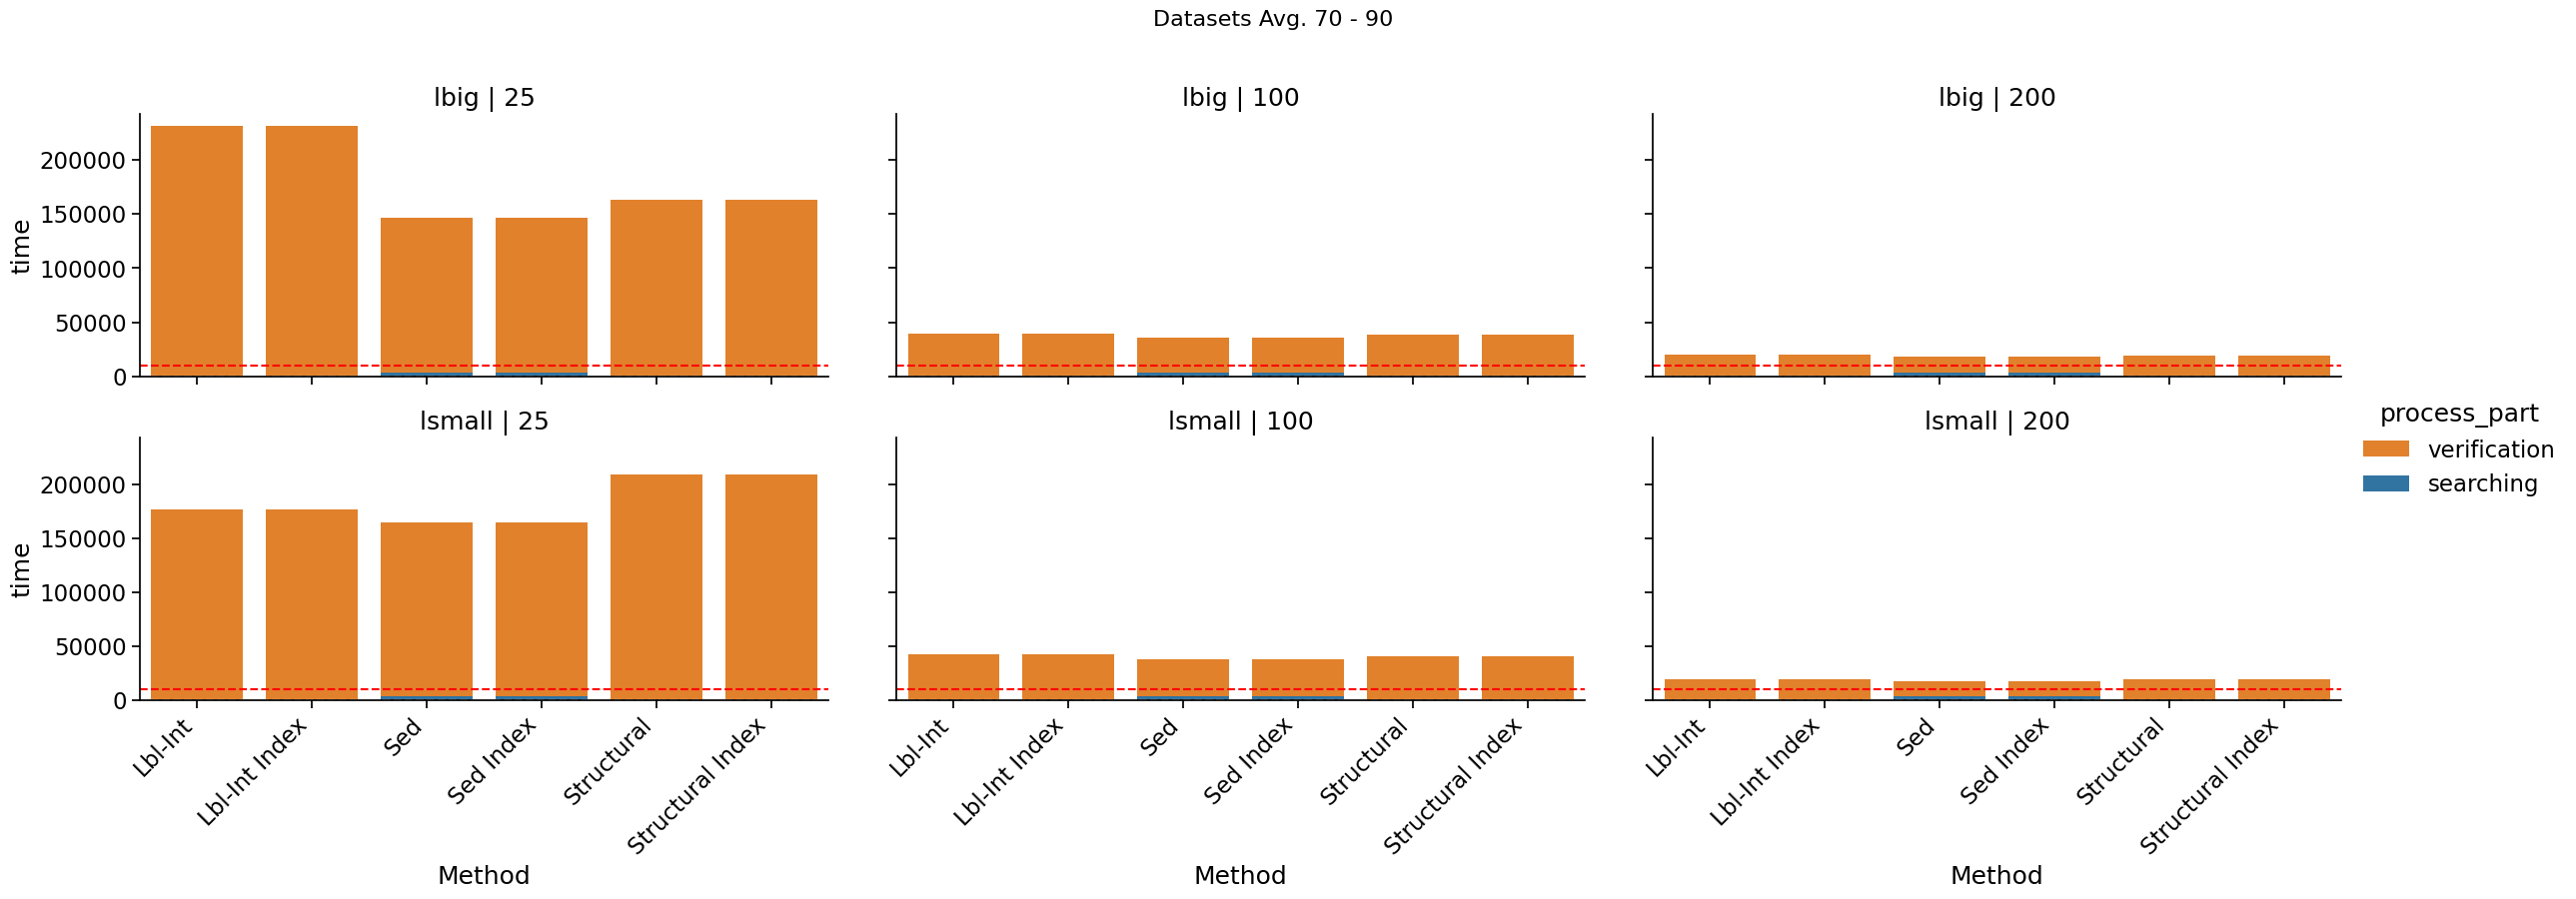

In [29]:
order = ['Lbl-Int', 'Lbl-Int Index', 'Sed', 'Sed Index', 'Structural', 'Structural Index']
# Increase overall font size
sns.set_context("notebook", font_scale=1.5)
g = sns.FacetGrid(
    alldf.sort_values('process_part', ascending=False).sort_values('Method'),
    col = 'BaseSize',
    row = 'LabelSize',
    hue = 'process_part',
    palette = hue_color_palette,
    height=4, aspect=2
    )
g = (g.map(sns.barplot, 'Method', 'time', errorbar = None, order=order).add_legend())

# g.set(yscale='log')

# Increase font size for titles, labels, and ticks
g.set_titles('{row_name} | {col_name}')   # Increase font size of titles
# g.set_axis_labels('Base Size', 'Value', fontsize=28)  # Axis labels font size
axes = g.axes.flatten()
for ax in axes:
    ax.axhline(y=10_000, color='r', linestyle='--')
    ax.axhline(y=10, color='white', linestyle='--')

# Set the super title
g.fig.suptitle("Datasets Avg. 70 - 90", fontsize=16)

# Adjust layout to make space for the super title
g.fig.subplots_adjust(top=0.85)  # Adjust this value as needed
# Rotate x-tick labels
for ax in g.axes.flat:
    ax.set_xticklabels(order, rotation=45, ha="right")  # Rotate labels by 45 degrees


# plt.suptitle('Times for 30-50 datasets')
# g.fig.subplots_adjust(hspace=0.2, wspace=0.35)
plt.show()
sns.set_context("notebook", font_scale=1)

In [30]:
data10: PlotData = get_plot_data_ds('resources/workloads/generated-10-20')
data30: PlotData = get_plot_data_ds('resources/workloads/generated-30-50')
data70: PlotData = get_plot_data_ds('resources/workloads/generated-70-90')
data1: PlotData = get_plot_data_ds('resources/workloads/generated-1-5')
data150: PlotData = get_plot_data_ds('resources/workloads/generated-150-200')

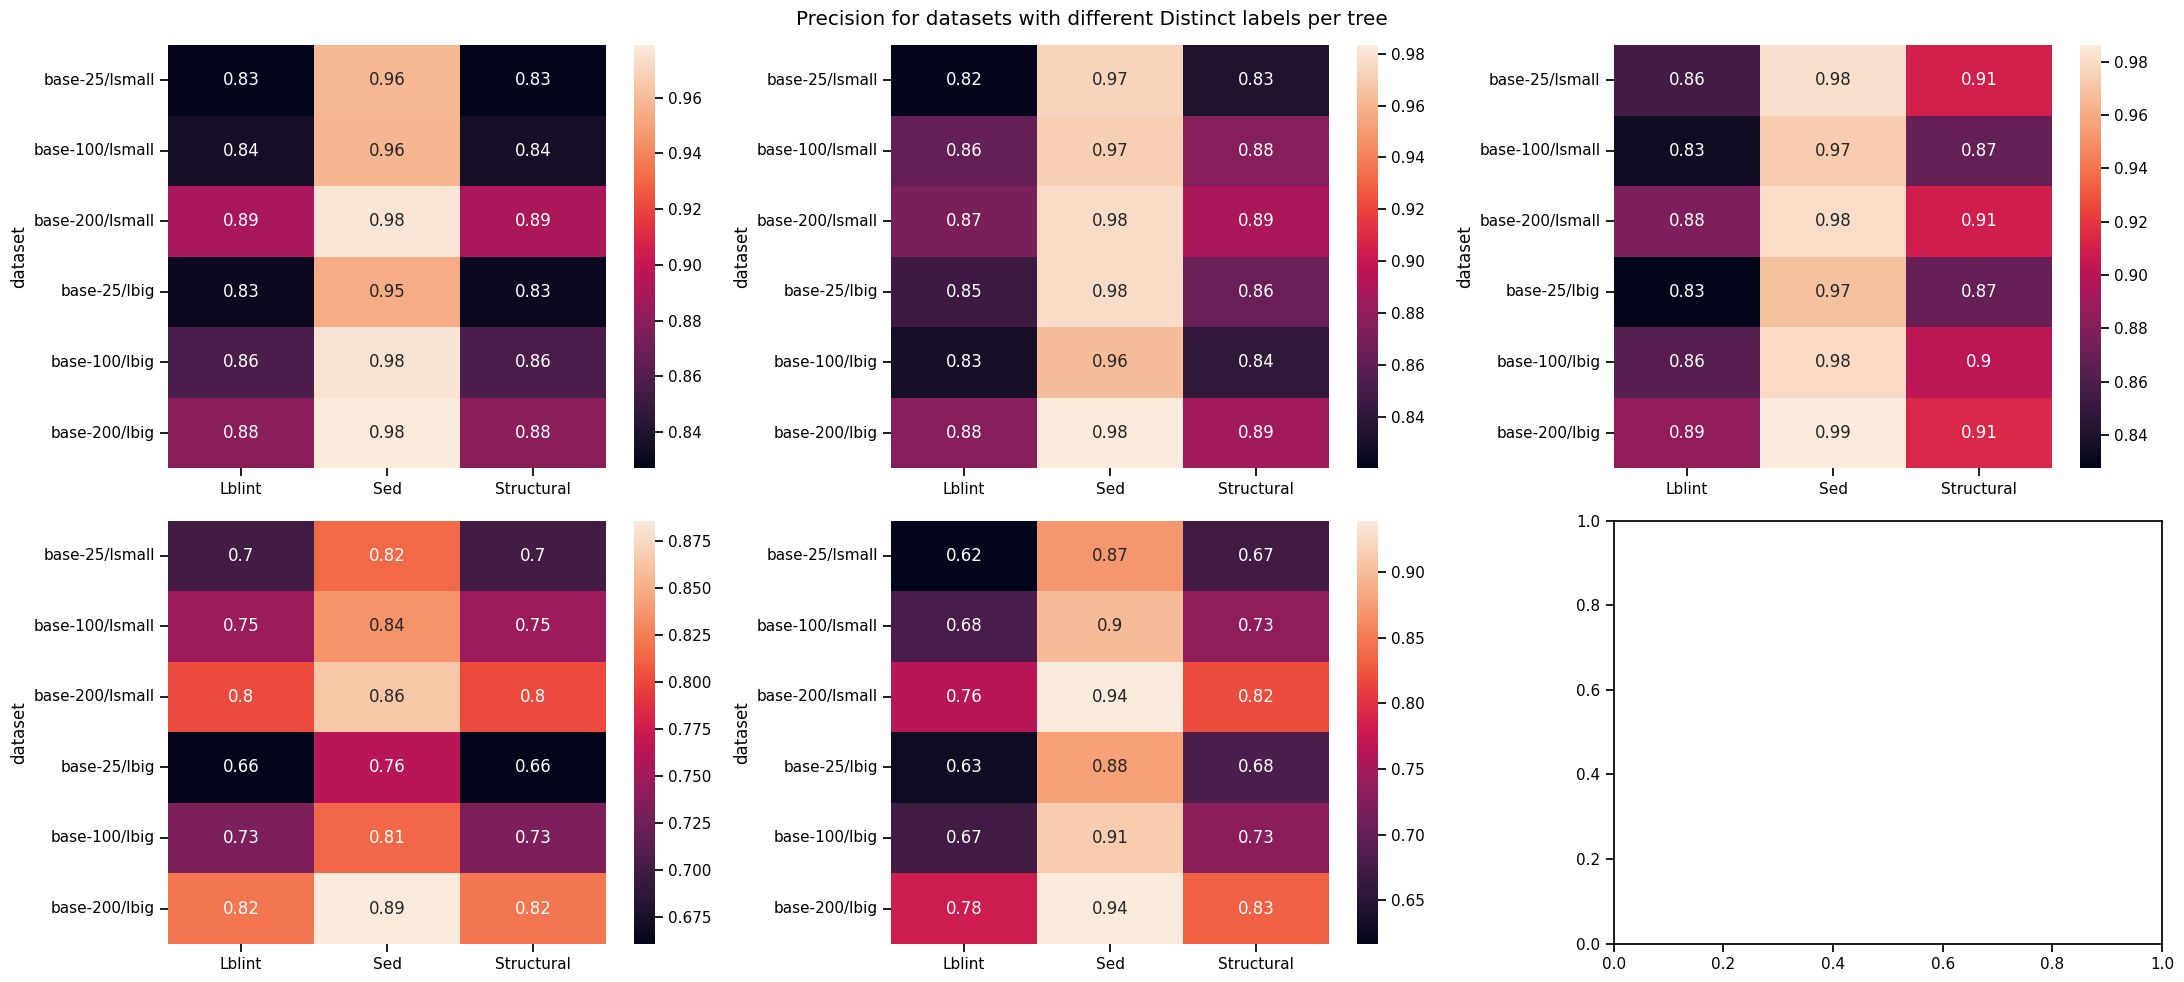

In [31]:
fig, axes = plt.subplots(2, 3, figsize=(22, 10))
hp1 = plot_precision(data10.pdf, axes[0][0])
hp2 = plot_precision(data30.pdf, axes[0][1])
hp3 = plot_precision(data70.pdf, axes[0][2])
hp4 = plot_precision(data1.pdf, axes[1][0])
hp5 = plot_precision(data150.pdf, axes[1][1])

fig.suptitle('Precision for datasets with different Distinct labels per tree')
fig.tight_layout()
# hp1

In [32]:
display(data1.statistics)
display(data150.statistics)

,Dataset,min_tree,max_tree,avg_tree,tree_count,avg_unique_labels_per_tree,avg_tree_distinct_labels,distinct_labels,Unnamed: 7
0,Base-25/lsmall,90,124,106.673,1000,0.041,21.455,2994,NaN
0,Base-100/lsmall,89,121,105.097,1000,0.058,19.804,2996,NaN
0,Base-200/lsmall,89,123,104.706,1000,0.087,17.658,2987,NaN
0,Base-25/lbig,91,122,106.260,1000,12.891,21.482,15494,NaN
0,Base-100/lbig,88,121,104.980,1000,12.105,19.935,14527,NaN
0,Base-200/lbig,91,122,104.758,1000,11.056,17.900,13336,NaN


,Dataset,min_tree,max_tree,avg_tree,tree_count,avg_unique_labels_per_tree,avg_tree_distinct_labels,distinct_labels,Unnamed: 7
0,Base-25/lsmall,91,122,106.331,1000,0.015,85.978,2996,NaN
0,Base-100/lsmall,91,121,104.835,1000,0.007,84.887,3001,NaN
0,Base-200/lsmall,90,125,104.767,1000,0.001,84.215,3001,NaN
0,Base-25/lbig,91,122,106.096,1000,12.302,87.102,16510,NaN
0,Base-100/lbig,89,123,105.586,1000,10.487,85.689,19296,NaN
0,Base-200/lbig,91,122,105.426,1000,8.509,85.448,22874,NaN


In [33]:
import matplotlib.pyplot as plt
# Function to create a broken axis
def make_broken_axis(ax, ylim_top, ylim_bottom, break_point):
    # ax.spines['bottom'].set_visible(False)
    # ax.spines['top'].set_visible(False)
    ax.set_ylim(ylim_bottom[0], ylim_bottom[1])
    
    ax2 = ax.twinx()
    ax2.spines['bottom'].set_visible(False)
    ax2.set_ylim(ylim_top[0], ylim_top[1])
    
    d = .015  # size of diagonal lines
    kwargs = dict(transform=ax.transAxes, color='k', clip_on=False)
    ax.plot((-d, +d), (-d, +d), **kwargs)
    ax.plot((1 - d, 1 + d), (-d, +d), **kwargs)
    
    kwargs.update(transform=ax2.transAxes)
    ax2.plot((-d, +d), (1 - d, 1 + d), **kwargs)
    ax2.plot((1 - d, 1 + d), (1 - d, 1 + d), **kwargs)
    
    # ax2.set_yticks([])
    ax.set_yticks(list(ax.get_yticks()) + list(ax2.get_yticks()))

/tmp/ipykernel_18490/1928924503.py:34: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(order, rotation=45, ha="right")  # Rotate labels by 45 degrees
/tmp/ipykernel_18490/1928924503.py:34: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(order, rotation=45, ha="right")  # Rotate labels by 45 degrees
/tmp/ipykernel_18490/1928924503.py:34: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(order, rotation=45, ha="right")  # Rotate labels by 45 degrees
/tmp/ipykernel_18490/1928924503.py:34: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(order, rotation=45, ha="right")  # Rotate labels by 45 degr

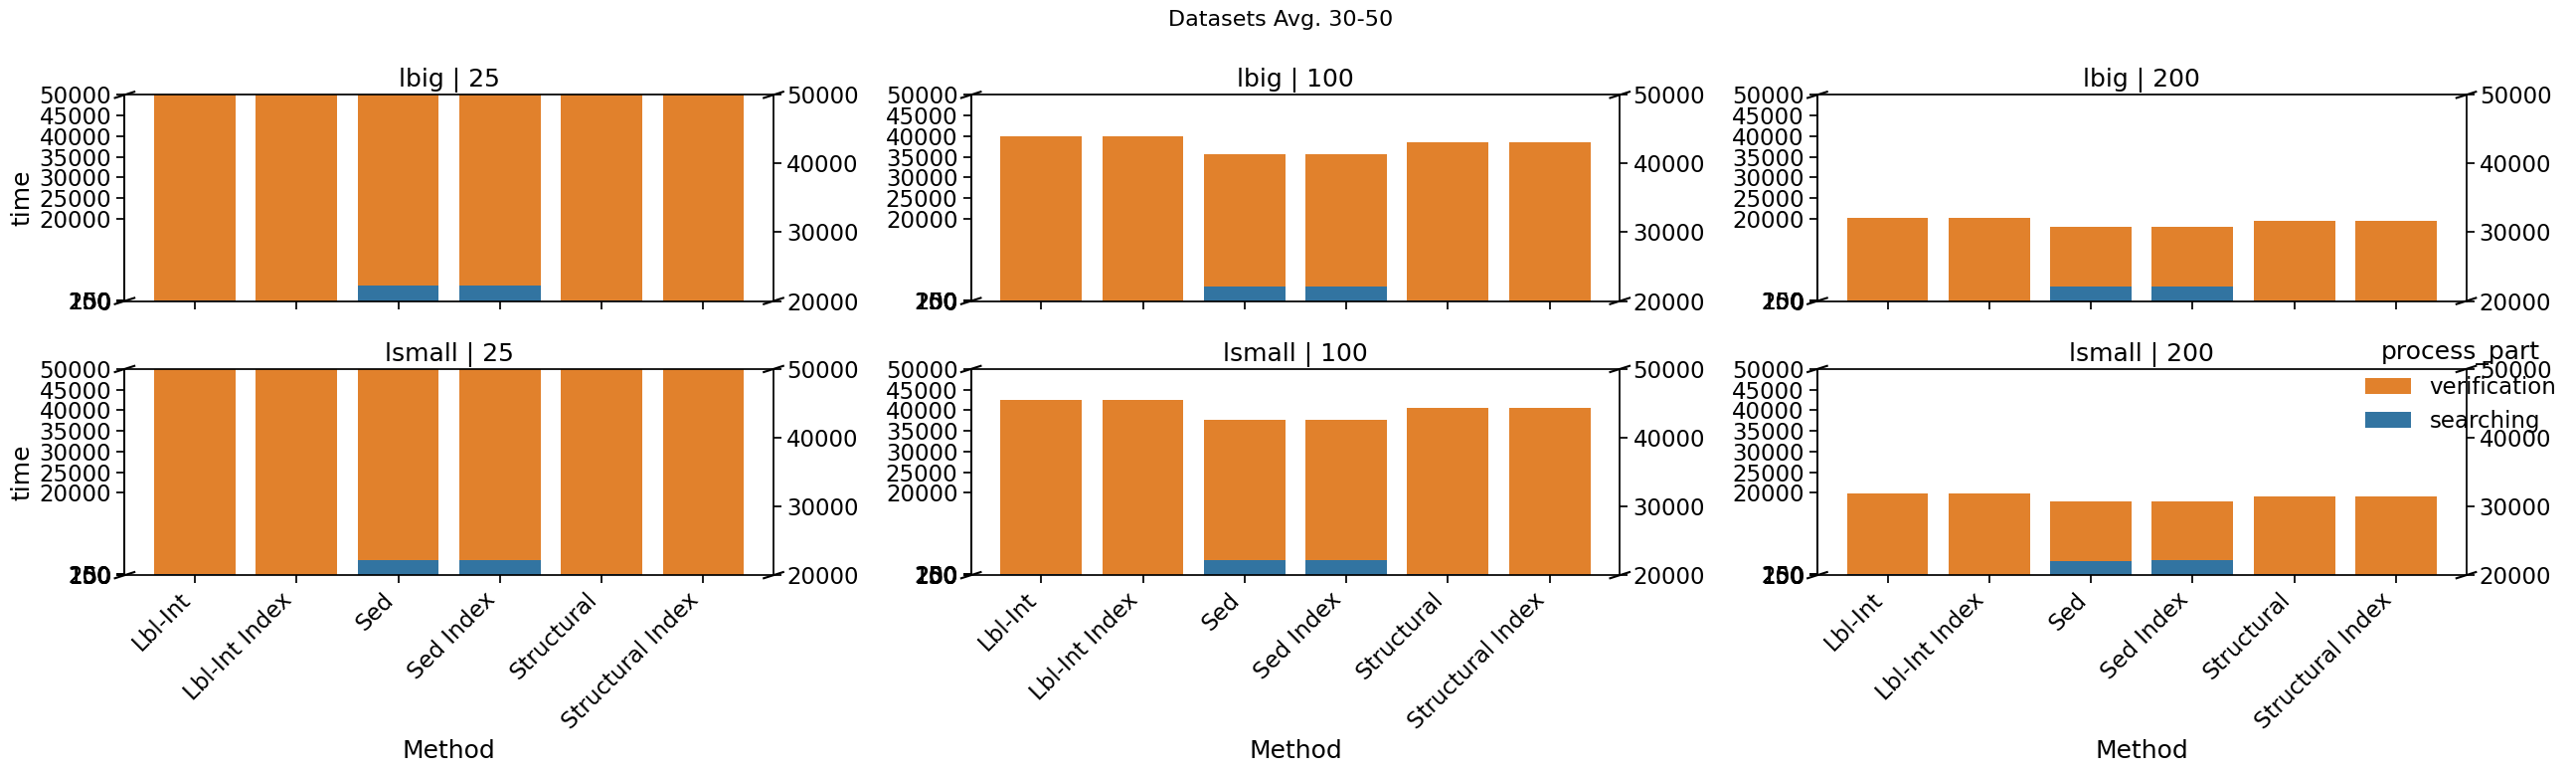

In [34]:
order = ['Lbl-Int', 'Lbl-Int Index', 'Sed', 'Sed Index', 'Structural', 'Structural Index']
# Increase overall font size
sns.set_context("notebook", font_scale=1.5)
g = sns.FacetGrid(
    alldf.sort_values('process_part', ascending=False).sort_values('Method'),
    col = 'BaseSize',
    sharey=False,
    row = 'LabelSize',
    hue = 'process_part',
    palette = hue_color_palette,
    height=4, aspect=2
    )
g = (g.map(sns.barplot, 'Method', 'time', errorbar = None, order=order).add_legend())

# g.set(yscale='log')

# Increase font size for titles, labels, and ticks
g.set_titles('{row_name} | {col_name}')   # Increase font size of titles
# g.set_axis_labels('Base Size', 'Value', fontsize=28)  # Axis labels font size
axes = g.axes.flatten()
for ax in axes:
    # ax.axhline(y=10_000, color='r', linestyle='--')
    # ax.axhline(y=10, color='white', linestyle='--')
    make_broken_axis(ax, ylim_top=(20_000, 50_000), ylim_bottom=(10, 250), break_point=50)
    # ax.set_yscale('log', base=math.e)

# Set the super title
g.fig.suptitle("Datasets Avg. 30-50", fontsize=16)

# Adjust layout to make space for the super title
g.fig.subplots_adjust(top=0.85)  # Adjust this value as needed
# Rotate x-tick labels
for ax in axes:
    ax.set_xticklabels(order, rotation=45, ha="right")  # Rotate labels by 45 degrees


# plt.suptitle('Times for 30-50 datasets')
# g.fig.subplots_adjust(hspace=0.2, wspace=0.35)
plt.tight_layout()
plt.show()
sns.set_context("notebook", font_scale=1)

In [35]:
data.plotdata[data.plotdata['Dataset'] == 'base-100/lbig']

process_part,Dataset,Method,searching,verification,total,BaseSize,LabelSize
0,base-100/lbig,Lbl-Int,187.0,39926.059287,40113.059287,100,lbig
1,base-100/lbig,Lbl-Int Index,10.0,39926.059287,39936.059287,100,lbig
2,base-100/lbig,Sed,3569.0,35557.990246,39126.990246,100,lbig
3,base-100/lbig,Sed Index,3619.0,35557.990246,39176.990246,100,lbig
4,base-100/lbig,Structural,205.0,38432.435468,38637.435468,100,lbig
5,base-100/lbig,Structural Index,4.0,38432.435468,38436.435468,100,lbig


# Generational Generated datasets values

In [38]:
datasets = ['sim-uhigh','sim-high', 'sim-med', 'sim-low']
# datasets = ['sim-med', 'sim-low']

In [86]:
from os.path import join
def get_query_runtime_for_ds(basepath: str, ds: str):
    min_times = list(range(99999, 99999 + 10))
    for try_number in range(1, 4):
        qt = join(basepath, ds, 'query-1', f'query_times_{try_number}.txt')
        # qt = f'resources/workloads/generated/{ds}/query_times.txt'
        with open(qt) as f:
            content = f.read().split('\n')

        times = [int(l.split(':')[1].strip('ms')) for i, l in enumerate(content) if i % 3 == 1]
        min_times = [min(a, b) for a, b in zip(min_times, times)]
        candidates = [l.split(':')[1] for i, l in enumerate(content) if i % 3 == 2]
        methods = [l for i, l in enumerate(content) if i % 3 == 0 and l]
        
  
    csv_content = ','.join(methods) + '\n' +','.join(map(str, min_times))  + '\n' + ','.join(candidates) + '\n'
    strio = StringIO(csv_content)
    df = pd.read_csv(strio)
    df.insert(0, 'Dataset', [ds] * 2)
    # df = df.set_index('Dataset')
    return df

In [40]:
def get_searching_part(basepath: str):
    df = pd.DataFrame()
    cdf = pd.DataFrame()
    stats_df = pd.DataFrame()
    for ds in datasets:
        tdf = get_query_runtime_for_ds(basepath, ds)
        df = pd.concat([df, tdf.iloc[[0]]])
        cdf = pd.concat([cdf, tdf.iloc[[1]]])
        stats = pd.read_csv(join(basepath, ds, 'collection.csv'))
        queries = pd.read_csv(join(basepath, ds, '1query.csv'), delimiter=';', header=None, names=['threshold', 'tree'])
        stats.insert(0, 'Dataset', [ds.capitalize()])
        stats.insert(1, 'Avg. query Tau', [queries['threshold'].mean()])
        stats_df = pd.concat([stats_df, stats])

    df = df.rename(columns={
        'Lblint index': ALGORITHMS['lblindex'],
        'Lblint': ALGORITHMS['lblint'],
        'Sed Index': ALGORITHMS['sedindex'],
        'Sed': ALGORITHMS['sed'],
        'Structural Index': ALGORITHMS['structuralindex'],
        'Structural': ALGORITHMS['structural'],
        })
    df = df.set_index('Dataset')
    cdf = cdf.set_index('Dataset')
    df['process_part'] = 'searching'

    return df, cdf, stats_df

In [72]:
# returns precision, verification times and selectivies
def get_precision_and_verification_for_ds(basepath: str, cdf: pd.DataFrame) -> (pd.DataFrame, pd.DataFrame, pd.DataFrame):
    # precision dataframe
    pdf = pd.DataFrame()
    # verification times dataframe
    vdf = pd.DataFrame()
    selectivites = dict()
    for ds in datasets:
        temp_df = pd.DataFrame.from_dict({ 'dataset': [ds] })
        tv_df = pd.DataFrame.from_dict({ 'Dataset': [ds] })
        times_ = []
        methods = ['Lbl-Int Index', 'Lbl-Int', 'Sed Index', 'Sed', 'Structural Index', 'Structural']
        df_all = pd.read_csv(join(basepath, ds, 'query-1', 'verified-all.txt'))
        for mtd in ('Lblint', 'Sed', 'Structural'):
            candidates_df = pd.read_csv(join(basepath, ds, 'query-1', f'{mtd}_candidates.csv'), header=None, names=['query_id', 'candidate_id'])
            method_verified_candidates_df = df_all.merge(candidates_df, on=['query_id', 'candidate_id'], how='inner')
            candidate_count = cdf[mtd][ds]

            times = method_verified_candidates_df['verification_time_micro']
            correct_results = method_verified_candidates_df[method_verified_candidates_df['passed'] == 1]
            precision =  len(correct_results) / candidate_count
            temp_df[mtd] = precision
            temp_df
            # convert from microseconds to milliseconds
            total_verification_time_ms = times.sum() / 1_000
            # twice for index version
            times_.extend([total_verification_time_ms, total_verification_time_ms])
        
        sdf = correct_results.rename({'query_id': 'T1', 'candidate_id': 'T2'}, axis='columns')
        sdf = sdf[sdf['T1'] != sdf['T2']].sort_values(by='T1')
        g = sdf.groupby('T1').count()
        g['T2'] = (g['T2'] / 1000) * 100
        selectivity = g.mean()['T2']
        selectivites[ds] = {'Selectivity':  selectivity }
        pdf = pd.concat([pdf, temp_df])
        vdf = pd.concat([vdf, pd.DataFrame.from_dict({'Dataset': [ds] * 6, 'process_part': ['verification'] * 6, 'Method': methods, 'Time': times_, }) ])
        
    
    sdf = pd.DataFrame.from_dict(selectivites)
    pdf = pdf.set_index("dataset")
    vdf.sort_values(['Method', 'Dataset'], inplace=True)
    return pdf, vdf, sdf


In [73]:
def get_dissimilarity(basepath: str):
    diss = pd.DataFrame()
    for ds in datasets:
        verification_path = join(basepath, ds, 'dissimilarity-verified.txt')
        with open(verification_path) as f:
            lines = f.read().split('\n')
        correct_results = [l for l in lines if ',' in l and l]
        df = pd.read_csv(StringIO('\n'.join(correct_results)), names=['T1', 'T2'])
        df = df[df['T1'] != df['T2']]
        g = df.groupby('T1').count()
        g['Dataset'] = ds
        g= g.rename(columns={"T2": 'Dissimilarity'})
        diss = pd.concat([diss, g])
    return diss

    

In [74]:
def get_plot_data_ds(basepath: str) -> PlotData:
    df, cdf, statistics = get_searching_part(basepath)
    pdf, vdf, sdf = get_precision_and_verification_for_ds(basepath, cdf)
    
    df['Dataset'] = df.index
    ldf = df.melt(id_vars=["Dataset", "process_part"], var_name="Method", value_name="Time", value_vars=['Lbl-Int Index', 'Lbl-Int', 'Sed Index', 'Sed', 'Structural Index', 'Structural'])
    complete = pd.concat([ldf, vdf])
    plot_data = complete.pivot_table(
        index=['Dataset', 'Method'],
        columns='process_part',
        values='Time'
    ).reset_index()
    plot_data['total'] = plot_data['searching'] + plot_data['verification']

    return PlotData(
        pdf = pdf,
        vdf = vdf,
        sdf = sdf,
        plotdata = plot_data,
        statistics = statistics,
        dissimilarity = get_dissimilarity(basepath)
    )

In [75]:
def plot_broken_stacked_bars(data, order, break_bottom=15, break_top=450, height_ratios=[2, 1], *args, **kwargs):
    # display(data)
    """Create a broken axis stacked bar plot"""
    # Create figure and gridspec
    ax = kwargs.get('ax', plt.gca())
    gs = gridspec.GridSpecFromSubplotSpec(2, 1, subplot_spec=ax.get_subplotspec(), height_ratios=height_ratios, hspace=0.10)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.spines['bottom'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
    # Create two axes
    ax1 = plt.Subplot(ax.figure, gs[0])
    ax2 = plt.Subplot(ax.figure, gs[1])
    ax.figure.add_subplot(ax1)
    ax.figure.add_subplot(ax2)

    # ax.set_xticks(data["Method"])
    # Plot stacks on both axes
    for ax in [ax1, ax2]:
        # Bottom stack
        sns.barplot(data=data, x='Method', y='searching', 
                   color=hue_color_palette['searching'], ax=ax, order=order)
        
        # Top stack
        sns.barplot(data=data, x='Method', y='verification',
                   bottom=data['searching'],
                   color=hue_color_palette['verification'], ax=ax, order=order)
        # ax.set_xticks([])
        ax.set_xlabel("") #Remove x label
        ax.set_ylabel("") #Remove y label

    for i, total in enumerate(data['total']):
        if total > break_top:
            ax1.text(i, total, f'{total:.1f}', ha='center', va='bottom')

    for i, search_time in enumerate(data['searching']):
        subax = ax2 if search_time < break_bottom else ax1
        # if search_time < break_bottom:
        subax.text(i, search_time, f'{search_time:.1f}', ha='center', va='bottom')
                        
    # Set the limits
    ax1.set_ylim(break_top, data['total'].max() * 1.2)
    ax2.set_ylim(0, break_bottom)
    
    # Hide the appropriate spines
    ax1.spines['bottom'].set_visible(False)
    ax2.spines['top'].set_visible(False)
    ax1.xaxis.set_visible(False)
    
    # Add break marks
    d = .005
    kwargs = dict(transform=ax2.transAxes, color='k', clip_on=False)
    ax2.plot((-d, +d), (1-d, 1+d), **kwargs)
    ax2.plot((1-d, 1+d), (1-d, 1+d), **kwargs)
    
    kwargs.update(transform=ax1.transAxes)
    ax1.plot((-d, +d), (-d, +d), **kwargs)
    ax1.plot((1-d, 1+d), (-d, +d), **kwargs)
    
    ax.tick_params(axis="x", rotation=45)
    return ax2

In [76]:
def plot_timesdata(plot_timesdata: pd.DataFrame):
    sns.set_context("notebook", font_scale=1)
    # Updated function to handle `FacetGrid` subsets
    
    
    order = ['Lbl-Int', 'Lbl-Int Index', 'Sed', 'Sed Index', 'Structural', 'Structural Index']
    # Increase overall font size
    sns.set_context("notebook", font_scale=1)
    g = sns.FacetGrid(
        plot_timesdata,
        col = 'BaseSize',
        row = 'LabelSize',
        palette = hue_color_palette,
        height=4, aspect=2
        )
    # g = (g.map(plot_broken_stacked_bars, break_bottom=15, break_top=150).add_legend())
    g.map_dataframe(plot_broken_stacked_bars, break_bottom=500, break_top=2_000, order=order)
    g.set_titles('{row_name} | {col_name}')
    # for ax in g.axes.flat:
    #     ax.set_xticklabels(order, rotation=45, ha="center")  # Rotate labels by 45 degrees

    # Crucial: Set x and y ticks AFTER mapping and BEFORE tight_layout
    for ax in g.axes.flat:
        ax.set_xticks([])  # Set the correct number of ticks
        ax.set_yticks([])
    
    # Add labels manually AFTER mapping
    # g.axes.flat[0].set_xlabel() #Set x label on the first axes of the grid
    # g.axes.flat[0].set_ylabel() #Set y label on the first axes of the grid
    
    g.set(xticklabels=[])
    g.set(yticklabels=[])
    # Example dataset
    plt.tight_layout()
    plt.show()

In [77]:
hue_color_palette = {'searching': sns.color_palette()[0], 'verification': sns.color_palette()[1]}

In [89]:
data: PlotData = get_plot_data_ds('resources/workloads/generational/generated-40-80/')
display(data.statistics)

,Dataset,Avg. query Tau,min_tree,max_tree,avg_tree,tree_count,avg_unique_labels_per_tree,avg_tree_distinct_labels,distinct_labels
0,Sim-uhigh,7.523333,96,105,98.448,1000,0.746,89.990,2015
0,Sim-high,23.673333,96,106,99.884,1000,0.855,97.112,3833
0,Sim-med,51.083333,96,106,100.658,1000,0.357,98.453,4782
0,Sim-low,78.676667,96,106,101.038,1000,0.092,99.589,4972


In [90]:
display(data.sdf)

,sim-uhigh,sim-high,sim-med,sim-low
Selectivity,0.925,0.865333,0.937667,0.901667


Text(0.5, 1.0, 'Dissimilarity (lower - dissimilar, higher - similar')

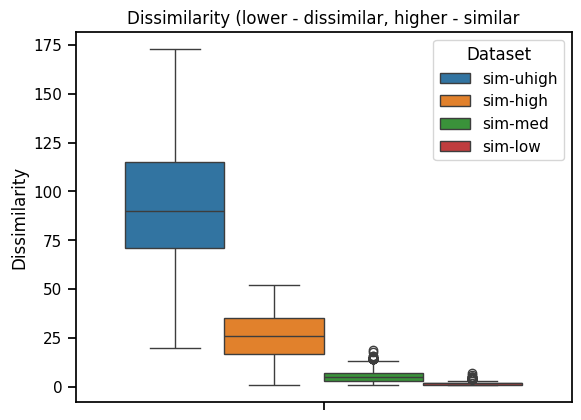

In [91]:
bxp = sns.boxplot(data.dissimilarity, y="Dissimilarity", hue="Dataset")
bxp.set_title('Dissimilarity (lower - dissimilar, higher - similar')

<Axes: ylabel='dataset'>

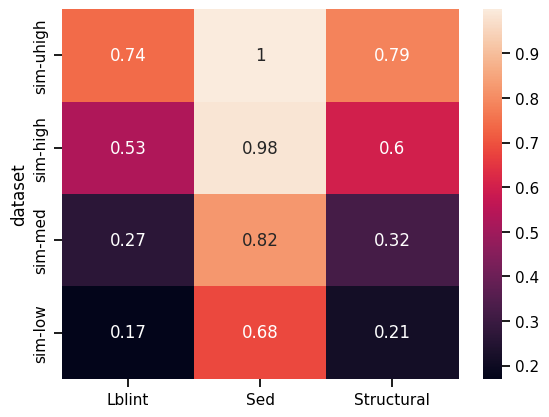

In [92]:
plot_precision(data.pdf)

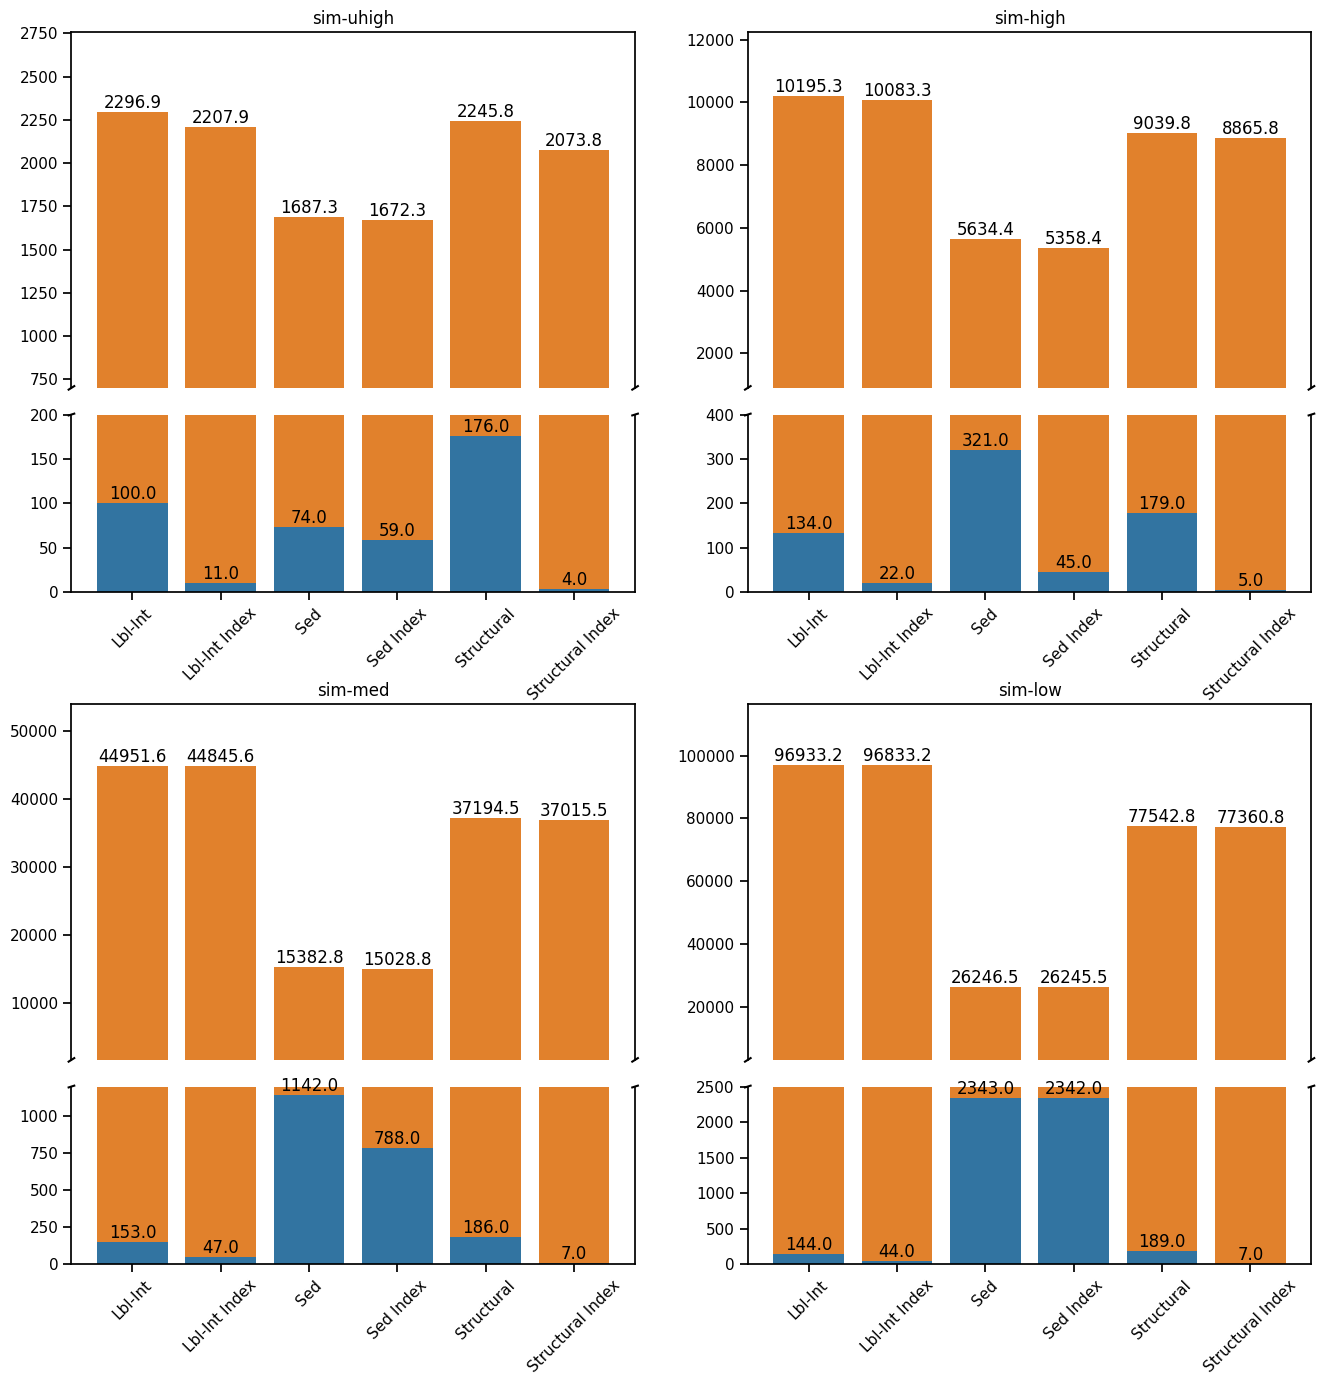

In [94]:
f, axes = plt.subplots(2, 2, figsize=(16, 16))
order = ['Lbl-Int', 'Lbl-Int Index', 'Sed', 'Sed Index', 'Structural', 'Structural Index']

breaks = {
    'sim-uhigh': 200,
    'sim-high': 400,
    'sim-med': 1200,
    'sim-low': 2500,
}

for ax, ds in zip(axes.ravel(), datasets):
    # print(ds)
    
    bottom_break = 400 
    plot_broken_stacked_bars(data.plotdata[data.plotdata['Dataset'] == ds], order, ax=ax, break_bottom = breaks[ds], break_top = breaks[ds] + 500)
    ax.set_title(ds)